## Vegas Odds and Fantasy Football Kickers
#### Matthew Johnson, August 9, 2018 (Last updated: August 13, 2018)

1. NFL Data
2. **Vegas odds**
3. Weather
<br><br>
Odds from: http://www.footballlocks.com/archived_nfl_odds_lines_point_spreads.shtml
<br>Currently have data for 2009-2017, weeks 6-16.

In [761]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
odd_list = []

for i in range(6,17):
    try:
        odds = pd.read_csv('/Users/mattjohnson/Desktop/Python2018/NFL/vegas_week'+str(i)+'.csv')
        odds['Week']=i
        odd_list.append(odds)
    except:
        print(i)

In [762]:
for _ in odd_list:
    print(_.shape)

(150, 7)
(143, 7)
(145, 7)
(142, 7)
(148, 7)
(149, 7)
(156, 7)
(161, 7)
(163, 7)
(144, 7)
(164, 7)


In [763]:
team_dict = {'Carolina': "CAR", 'Houston': "HOU", 'New England': "NE", 'Atlanta': "ATL",
 'New Orleans': "NO", 'Green Bay': "GB", 'Baltimore': "BAL", 'Washington': "WAS", 
 'Jacksonville': "JAX", 'Tampa Bay': "TB", 'Kansas City': "KC", 'Oakland':  "OAK",
 'Denver': "DEN", 'Tennessee': "TEN", 'NY Giants': "NYG", 'Pittsburgh': "PIT",
 'Chicago': "CHI", 'Buffalo': "BUF", 'Detroit': "DET", 'Philadelphia': "PHI",
 'Seattle': "SEA", 'Arizona': "ARI", 'lanta':"ATL", 'Cincinnati': "CIN", 'Los Angeles': "LAR",
 'Minnesota':"MIN", 'NY Jets':"NYJ", 'rizona':"ARI", 'Indianapolis': "IND", 
 'Cleveland': "CLE",'San Diego': "SD",'San Francisco': "SF", 'Dallas': "DAL",
 'LA Rams': "LAR",'St. Louis': "STL", 'Miami':"MIA", 'LA Chargers': "LAC"}

In [809]:
def clean_odds_data(odd_list):
    odds_df = pd.concat(odd_list)
    odds_df.dropna(thresh=2, inplace=True)
    
    odds_df['Favorite'] = odds_df['Favorite'].astype(str)
    odds_df['Underdog'] = odds_df['Underdog'].astype(str)  #.str.replace('\D+', '')

    odds_df['Favorite'] = odds_df['Favorite'].map(lambda x: x.lstrip('At\s'))
    odds_df['Underdog'] = odds_df['Underdog'].map(lambda x: x.lstrip('At\s'))
    odds_df['Favorite'] = odds_df['Favorite'].str.strip()
    odds_df['Underdog'] = odds_df['Underdog'].str.strip()
    
    odds_df['favourite'] = odds_df['Favorite'].map(team_dict)
    odds_df['underdog'] = odds_df['Underdog'].map(team_dict)

    odds_df = odds_df[ odds_df['Date & Time'] != 'Date & Time']

    odds_df['Date'] = odds_df['Date & Time'].str[0:5].str.strip()
    
    df_odds = odds_df['Date'].str.split('/').apply(pd.Series)
    for col in df_odds.columns:
        df_odds[col] =  df_odds[col].astype(str).apply(lambda x: x.zfill(2))
    
    odds_df['Date'] = df_odds[0] + '/' + df_odds[1]
    
    odds_df.drop(['Favorite', 'Underdog', 'Date & Time'], axis=1, inplace=True)
        
    odds_df = odds_df[~odds_df['Line'].str.contains("[a-zA-Z]").fillna(False)]
    odds_df['Line'] = pd.to_numeric(odds_df['Line'])
    odds_df['Total'] = pd.to_numeric(odds_df['Total'])
    
    # add relative line
    odds_df['fav_line'] = odds_df['Line']
    odds_df['underdog_line'] = odds_df['Line']*(-1)
    
    missing_values_count = odds_df.isnull().sum()
    
    fav_df = odds_df[['Season', 'Week', 'Date', 'favourite', 'underdog', 'fav_line', 'Total']]
    underdog_df = odds_df[['Season', 'Week', 'Date', 'underdog', 'favourite', 'underdog_line', 'Total']]

    fav_df.columns = ['Season', 'Week', 'Date', 'OffenseTeam', 'DefenseTeam', 'Relative_Line', 'Total']
    underdog_df.columns = ['Season', 'Week', 'Date', 'OffenseTeam', 'DefenseTeam', 'Relative_Line', 'Total']

    odds_data = pd.concat([fav_df, underdog_df])
    odds_data['Total'] = pd.to_numeric( odds_data['Total'] )
    odds_data['Exp_Pts'] = odds_data['Relative_Line'] + odds_data['Total']
    
    odds_data['Season'] = odds_data['Season'].fillna(0)
    odds_data['Season'] = odds_data['Season'].astype('int64')
    odds_data['Season'] = odds_data['Season'].astype(str)
    odds_data['Date'] = odds_data['Date'].astype(str)
    odds_data['OffenseTeam'] = odds_data['OffenseTeam'].astype(str)

    odds_data['mergeCode'] = odds_data['Season'] + '-' + odds_data['Date'] + '-'+ odds_data['OffenseTeam']
    odds_data['mergeCode2'] = odds_data['Season']+'-'+ odds_data['Week'].astype(str)+'-' + odds_data['OffenseTeam']

    odds_data.fillna(0, inplace=True)
    
    return odds_data

## Start

In [810]:
odds_data = clean_odds_data(odd_list)

In [811]:
#odds_data.to_csv('vegas_odds09to17.csv') # weeks 6-16

In [766]:
train_list = []
y_list = []

for year in range(2009,2018):
    data = pd.read_csv('/Users/mattjohnson/Desktop/Python2018/NFL/fantasy_kickers' + str(year)+'.csv')
    data.drop([ 'Drive', 'DEF_Drive', 'DEF_Week', 'DEF_gameid', 
           'CompletePass_rolling5', 'ExPointBad_rolling5', 'TwoPointGood_rolling5', 
           'DEF_TwoPointConv_rolling5', 'DEF_CompletePass_rolling5', 'DEF_ExPointBad_rolling5', 
           'DEF_TwoPointGood_rolling5','DEF_FieldGoalBad_rolling5', 'DEF_Kicker_Pts'], 
          axis=1, inplace=True)
    data = data[ data['Week'] <= 13 ]
    X = data.drop('Kicker_Pts', axis=1)
    y = data['Kicker_Pts']
    train_list.append(X)
    y_list.append(y)
    
X = pd.concat(train_list)
y = pd.concat(y_list)

In [767]:
# for now
X = pd.concat([X,y], axis=1)

In [768]:
X['gameid'] = X['gameid'].astype(str)
X['date'] = (X['gameid'].str[4:6] + '/' + X['gameid'].str[6:8]).str.lstrip('0')
X['offenseTeam']= X['offenseTeam'].str[0:4].str.strip('-')
X['offenseTeam']= X['offenseTeam'].str.rstrip('-2')
X['Season'] = X['Season'].astype(str)
X['mergeCode'] = X['Season'] + '-' + X['date'] +'-'+ X['offenseTeam']

all_data = pd.merge(odds_data.reset_index(drop=True), X.reset_index(drop=True), 
                    on='mergeCode', how='outer')

In [769]:
print(all_data.shape, '-', odds_data.shape, '-', X.shape)

(2971, 57) - (2878, 9) - (2108, 49)


In [771]:
all_data_drop.to_csv('weeks6to16_vegas_and_stats.csv')

In [791]:
from sklearn.model_selection import train_test_split
X = all_data_drop.select_dtypes(include=['int64', 'float64'])
Xtrain, Xtest, ytrain, ytest = train_test_split(X.drop('Kicker_Pts', axis=1), X['Kicker_Pts'])

In [792]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 2018)
rf.fit(Xtrain, ytrain);

In [793]:
predictions = rf.predict(Xtest)
errors = abs(predictions - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 3.3


In [794]:
temp = all_data_drop[['Relative_Line', 'Exp_Pts', 'Kicker_Pts_rolling5', 'DEF_Kicker_Pts_rolling5', 'Kicker_Pts']]

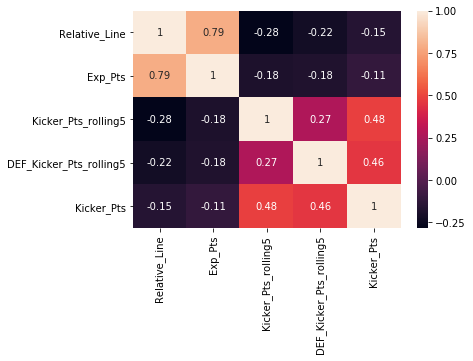

In [799]:
sns.heatmap(temp.corr(), annot=True)